<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37 - Part 2: Regression Benchmarking & Optimization</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

---
## Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Feature Selection](#2-feature-selection)
3. [Regression Benchmarking](#3-benchmarking)
4. [Model Optimization - Ensemble & Stacking](#4-optimization)
5. [Deployment - Final Submission](#5-deployment)


---

<a id='1-setup'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>1 | Setup & Data Loading</b></span>
    </h1>
</div>

### 1.1 Import Libraries

In [31]:
# Standard library
from itertools import combinations

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# Sklearn - Base
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

# Sklearn - Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold

# Sklearn - Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    ExtraTreesRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Sklearn - Metrics
from sklearn.metrics import (
    mean_absolute_error, 
    root_mean_squared_error, 
    mean_pinball_loss, 
    make_scorer
)

# MLxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Local - Custom preprocessing pipeline
from preprocessing_pipeline import CarPreprocessingPipeline

# Plot style
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']

### 1.2 Load Data

In [32]:
# Load dictionary for brand/model cleaning
brand_model_dic = pd.read_parquet("./project_data/brand_model_dic.parquet", engine="pyarrow")

# Load the datasets (train, validation, test)
X_train_scaled = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val_scaled   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test_scaled  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

print(f"Train: {X_train_scaled.shape[0]:,} rows, {X_train_scaled.shape[1]} features")
print(f"Val:   {X_val_scaled.shape[0]:,} rows")
print(f"Test:  {X_test_scaled.shape[0]:,} rows")

Train: 60,764 rows, 21 features
Val:   15,193 rows
Test:  32,567 rows


In [33]:
# Prepare target arrays and combined datasets
all_features = list(X_train_scaled.columns)

# Target arrays
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array   = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# Log transformation of target (reduces impact of outliers)
y_train_log = np.log1p(y_train_array)
y_val_log   = np.log1p(y_val_array)

# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

print(f"Train samples: {len(y_train_array):,}")
print(f"Val samples:   {len(y_val_array):,}")
print(f"Full samples:  {len(y_train_full_array):,}")

Train samples: 60,764
Val samples:   15,193
Full samples:  75,957


<a id='2-feature-selection'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2 | Feature Selection</b></span>
    </h1>
</div>

We use embedded methods (feature importance from tree models) to select the most relevant features for each algorithm.

### 2.1 Helper Functions

In [34]:
def plot_importance_unified(importance_series, name, is_tree_model=False):
    """Plot top 20 features by importance"""
    imp_coef = importance_series.sort_values(ascending=False).head(20)
    
    color = palette[1] if is_tree_model else palette[0]
    plt.figure(figsize=(9, 6))
    imp_coef.sort_values().plot(kind="barh", color=color) 
    
    plt.title(f"Feature Importance - {name} (Top 20)", fontsize=15)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


def print_selection_results(importance_series, model_name, threshold=None):
    """Print selected features based on importance threshold"""
    if threshold is None:
        threshold = importance_series.mean()
    
    selected = importance_series[importance_series > threshold].index.tolist()
    
    print(f"\n{'-'*60}")
    print(f"MODEL: {model_name}")
    print(f"Threshold: {threshold:.4f}")
    print(f"Selected: {len(selected)} features")
    print(f"Features: {selected}")
    print(f"{'-'*60}\n")
    
    return selected

### 2.2 Calculate Feature Importance per Model

In [35]:
# Gradient Boosting - Feature Importance
gb_base = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=37)
gb_base.fit(X_train_scaled, y_train_array)
gb_importance = pd.Series(gb_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# Random Forest - Feature Importance
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train_array)
rf_importance = pd.Series(rf_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# KNN - Correlation-based importance (since KNN has no native feature importance)
knn_importance = pd.Series({
    feat: np.abs(np.corrcoef(X_train_scaled[feat], y_train_array)[0, 1])
    for feat in X_train_scaled.columns
}).sort_values(ascending=False)

# Display importance rankings
print("\n" + "="*70)
print("FEATURE IMPORTANCE RANKINGS")
print("="*70)

for name, imp in [('Gradient Boosting', gb_importance), ('Random Forest', rf_importance), ('KNN (Correlation)', knn_importance)]:
    print(f"\n{name} - Top 10:")
    print(imp.head(10).to_string())


FEATURE IMPORTANCE RANKINGS

Gradient Boosting - Top 10:
engineSize              0.280896
transmission_manual     0.271784
age                     0.209492
mpg                     0.068740
mileage                 0.067866
carID                   0.032968
brand_model_freq_enc    0.031938
Brand_freq_enc          0.018392
tax                     0.008403
fuelType_petrol         0.003632

Random Forest - Top 10:
transmission_manual     0.305709
engineSize              0.281243
age                     0.255424
mpg                     0.040459
mileage                 0.035898
brand_model_freq_enc    0.031172
carID                   0.022447
Brand_freq_enc          0.012214
miles_per_year          0.005257
tax                     0.004503

KNN (Correlation) - Top 10:
engineSize                0.615766
transmission_manual       0.529927
age                       0.479517
transmission_semi auto    0.409241
mileage                   0.409013
tax                       0.307570
mpg               

c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


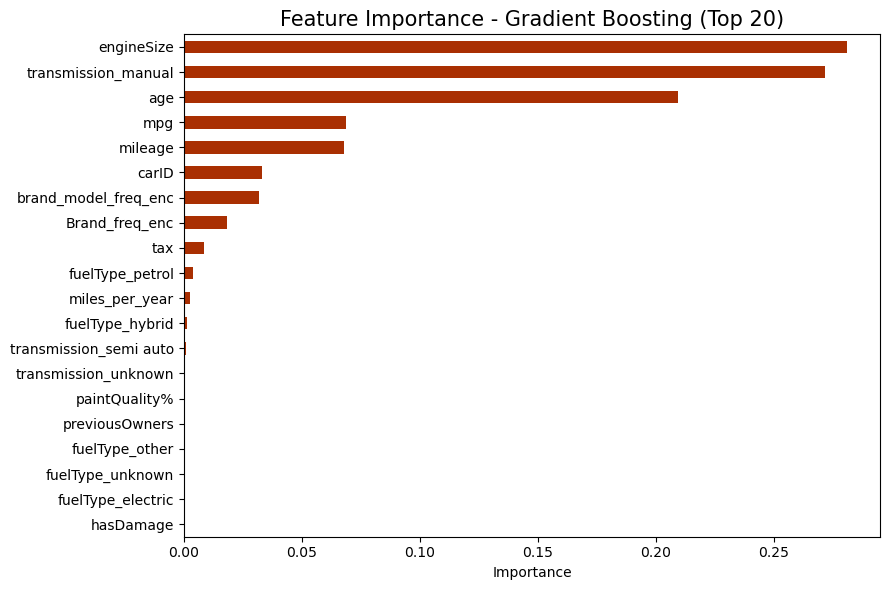

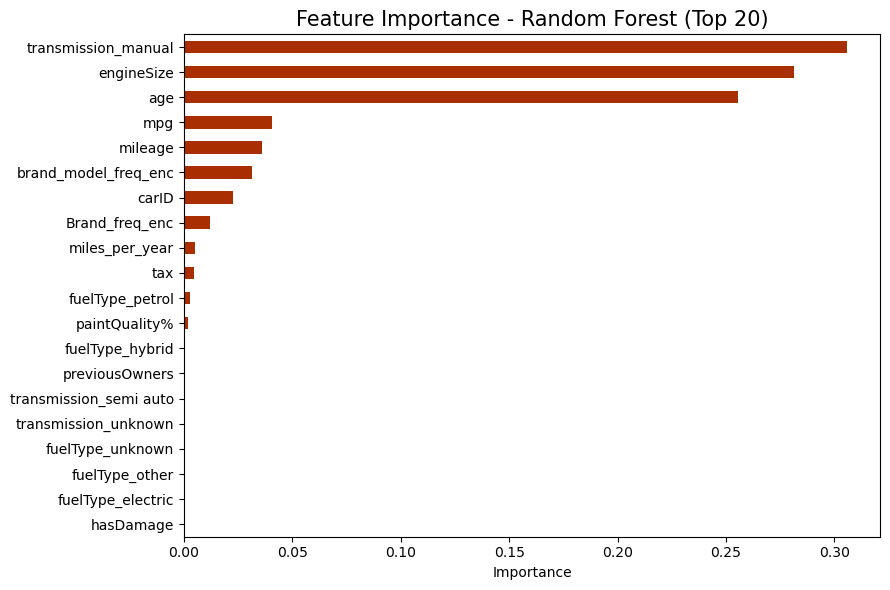

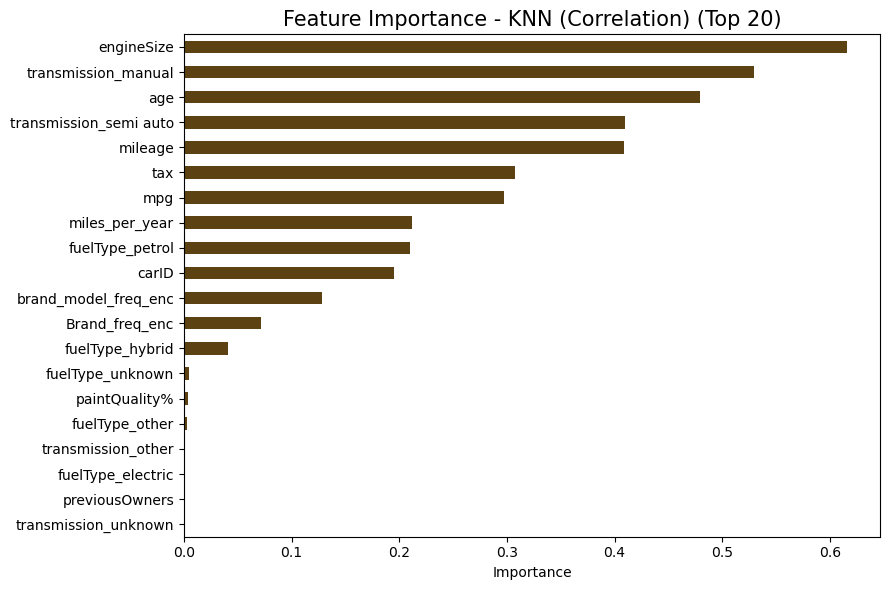

In [36]:
# Plot feature importance
plot_importance_unified(gb_importance, "Gradient Boosting", is_tree_model=True)
plot_importance_unified(rf_importance, "Random Forest", is_tree_model=True)
plot_importance_unified(knn_importance, "KNN (Correlation)", is_tree_model=False)

### 2.3 Select Optimal Number of Features

We test different numbers of top features (8-15) to find the optimal subset for each model.

In [37]:
# Store best results per model
best_results = {
    'GB':  {'features': gb_importance.index.tolist(),  'best_n': 10, 'best_mae': float('inf')},
    'RF':  {'features': rf_importance.index.tolist(),  'best_n': 10, 'best_mae': float('inf')},
    'KNN': {'features': knn_importance.index.tolist(), 'best_n': 10, 'best_mae': float('inf')}
}

print("\nTesting different numbers of features...\n")

for n_features in range(8, 16):
    print(f"{'='*70}")
    print(f"Testing {n_features} features:")
    print(f"{'='*70}\n")
    
    # GB
    gb_feats = gb_importance.index[:n_features].tolist()
    gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.08, random_state=37)
    gb_model.fit(X_train_scaled[gb_feats], y_train_array)
    gb_mae = mean_absolute_error(y_val_array, gb_model.predict(X_val_scaled[gb_feats]))
    print(f"   GB (top {n_features}):  VAL MAE: £{gb_mae:,.2f}")
    if gb_mae < best_results['GB']['best_mae']:
        best_results['GB']['best_mae'] = gb_mae
        best_results['GB']['best_n'] = n_features
    
    # RF
    rf_feats = rf_importance.index[:n_features].tolist()
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=37, n_jobs=-1)
    rf_model.fit(X_train_scaled[rf_feats], y_train_array)
    rf_mae = mean_absolute_error(y_val_array, rf_model.predict(X_val_scaled[rf_feats]))
    print(f"   RF (top {n_features}):  VAL MAE: £{rf_mae:,.2f}")
    if rf_mae < best_results['RF']['best_mae']:
        best_results['RF']['best_mae'] = rf_mae
        best_results['RF']['best_n'] = n_features
    
    # KNN (uses scaled data)
    knn_feats = knn_importance.index[:n_features].tolist()
    knn_model = KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)
    knn_model.fit(X_train_scaled[knn_feats], y_train_array)
    knn_mae = mean_absolute_error(y_val_array, knn_model.predict(X_val_scaled[knn_feats]))
    print(f"   KNN (top {n_features}): VAL MAE: £{knn_mae:,.2f}\n")
    if knn_mae < best_results['KNN']['best_mae']:
        best_results['KNN']['best_mae'] = knn_mae
        best_results['KNN']['best_n'] = n_features

# Summary
print("\n" + "="*70)
print("BEST NUMBER OF FEATURES PER MODEL")
print("="*70)
for model, results in best_results.items():
    print(f"   {model}: {results['best_n']} features → VAL MAE: £{results['best_mae']:,.2f}")


Testing different numbers of features...

Testing 8 features:

   GB (top 8):  VAL MAE: £1,462.63
   RF (top 8):  VAL MAE: £1,497.89
   KNN (top 8): VAL MAE: £2,409.09

Testing 9 features:

   GB (top 9):  VAL MAE: £1,461.26
   RF (top 9):  VAL MAE: £1,506.73
   KNN (top 9): VAL MAE: £2,372.63

Testing 10 features:

   GB (top 10):  VAL MAE: £1,445.00
   RF (top 10):  VAL MAE: £1,496.74
   KNN (top 10): VAL MAE: £5,557.82

Testing 11 features:

   GB (top 11):  VAL MAE: £1,440.54
   RF (top 11):  VAL MAE: £1,487.15
   KNN (top 11): VAL MAE: £5,563.71

Testing 12 features:

   GB (top 12):  VAL MAE: £1,439.68
   RF (top 12):  VAL MAE: £1,500.24
   KNN (top 12): VAL MAE: £5,563.82

Testing 13 features:

   GB (top 13):  VAL MAE: £1,444.97
   RF (top 13):  VAL MAE: £1,500.91
   KNN (top 13): VAL MAE: £5,562.10

Testing 14 features:

   GB (top 14):  VAL MAE: £1,442.29
   RF (top 14):  VAL MAE: £1,505.61
   KNN (top 14): VAL MAE: £5,562.47

Testing 15 features:

   GB (top 15):  VAL MAE: 

<a id='3-benchmarking'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

We use a **holdout validation strategy** (80/20 split) to evaluate models. The primary metric is **Mean Absolute Error (MAE)** as it directly represents the average prediction error in pounds.

### 3.1 Evaluation Function

In [38]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Calculate train and validation metrics"""
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val, y_val_pred),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

### 3.2 Hyperparameter Grid Search

In [39]:
# Define model configurations with hyperparameter grids
# Using model-specific feature subsets and scaling

models_and_grids = {
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=37),
        "params": {
            'learning_rate': [0.06, 0.07, 0.08, 0.09],
            'max_depth': [7, 9, 11],
            'min_samples_leaf': [2, 3],
            'n_estimators': [500, 700],
            'subsample': [0.8, 0.9, 1.0]
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['GB']['features'][:best_results['GB']['best_n']]
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [100, 130, 150],
            'max_depth': [15, 20, 25],
            'min_samples_leaf': [2, 3],
            'max_features': [0.6, 0.7, 0.8]
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['RF']['features'][:best_results['RF']['best_n']]
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [7, 10, 12, 15],
            'weights': ['uniform', 'distance']
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['KNN']['features'][:best_results['KNN']['best_n']]
    }
}

In [ ]:
# Run grid search for each model
results_list = []

for model_name, config in models_and_grids.items():
    print(f"\n{'='*70}")
    print(f"Grid Search: {model_name}")
    print(f"{'='*70}")
    
    X_tr = config['X_train'][config['features']]
    X_vl = config['X_val'][config['features']]
    
    param_grid = ParameterGrid(config['params'])
    best_val_mae = float('inf')
    best_result = None
    
    for i, params in enumerate(param_grid):
        model = clone(config['model'])
        model.set_params(**params)
        model.fit(X_tr, y_train_array)
        
        scores = evaluate_model(model, X_tr, y_train_array, X_vl, y_val_array)
        
        if scores['Val MAE'] < best_val_mae:
            best_val_mae = scores['Val MAE']
            best_result = {
                'Model': model_name,
                'Best Params': str(params),
                **scores
            }
            print(f"   New best: {params} → VAL MAE: £{scores['Val MAE']:,.2f}")
    
    results_list.append(best_result)
    print(f"\n✅ Best {model_name} VAL MAE: £{best_val_mae:,.2f}")

# Create results DataFrame
results_df = pd.DataFrame(results_list).sort_values('Val MAE')
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
display(results_df[['Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Best Params']])


Grid Search: GradientBoosting
   New best: {'learning_rate': 0.06, 'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 500, 'subsample': 0.8} → VAL MAE: £1,375.11
   New best: {'learning_rate': 0.06, 'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 500, 'subsample': 0.9} → VAL MAE: £1,371.24
   New best: {'learning_rate': 0.06, 'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 700, 'subsample': 0.8} → VAL MAE: £1,352.80
   New best: {'learning_rate': 0.06, 'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 700, 'subsample': 0.9} → VAL MAE: £1,348.53


<a id='4-optimization'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>4 | Model Optimization - Stacking Ensemble</b></span>
    </h1>
</div>

We use **Stacking** to combine our three best models (GB, RF, KNN). Stacking trains a meta-learner (Ridge regression) on the predictions of base models, learning optimal combination weights automatically via cross-validation.

Additionally, we apply **log transformation** to the target variable, which reduces the impact of price outliers and typically improves MAE in price prediction tasks.

### 4.1 Extract Best Parameters

In [ ]:
# Extract best hyperparameters from grid search
best_params = {}
for model_name in results_df['Model'].unique():
    params_str = results_df[results_df['Model'] == model_name]['Best Params'].values[0]
    best_params[model_name] = eval(params_str)
    print(f"{model_name}: {best_params[model_name]}")

### 4.2 Train Stacking Model

In [ ]:
# Define feature subsets for stacking
gb_features  = best_results['GB']['features'][:best_results['GB']['best_n']]
rf_features  = best_results['RF']['features'][:best_results['RF']['best_n']]
knn_features = best_results['KNN']['features'][:best_results['KNN']['best_n']]

# Union of all features (stacking uses all)
all_features = list(set(gb_features + rf_features + knn_features))
print(f"Features for stacking: {len(all_features)}")

# Create stacking model
stacking_model = StackingRegressor(
    estimators=[
        ('gb', GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)),
        ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)),
        ('knn', KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1))
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train with LOG-transformed target
print("Training stacking model with log(price)...", end=" ", flush=True)
stacking_model.fit(X_train_scaled[all_features], y_train_log)
print("✅")

# Evaluate on validation (convert predictions back to original scale)
stacking_train_pred_log = stacking_model.predict(X_train_scaled[all_features])
stacking_train_pred = np.expm1(stacking_train_pred_log)  # exp(x) - 1 to invert log1p
stacking_train_mae = mean_absolute_error(y_val_array, stacking_train_pred)

# Evaluate on validation (convert predictions back to original scale)
stacking_val_pred_log = stacking_model.predict(X_val_scaled[all_features])
stacking_val_pred = np.expm1(stacking_val_pred_log)  # exp(x) - 1 to invert log1p
stacking_val_mae = mean_absolute_error(y_val_array, stacking_val_pred)

print(f"\n✅ Stacking TRAIN MAE: £{stacking_train_mae:,.2f}")
print(f"\n✅ Stacking VAL MAE: £{stacking_val_mae:,.2f}")

# Compare with individual models
print("\nComparison with individual models:")
for _, row in results_df.iterrows():
    print(f"   {row['Model']}: £{row['Val MAE']:,.2f}")
print(f"   Stacking: £{stacking_val_mae:,.2f}")

<a id='5-deployment'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>5 | Deployment - Final Submission</b></span>
    </h1>
</div>

Retrain the stacking model on the full dataset (train + validation) and generate predictions for the test set.

In [ ]:
# Retrain stacking on full data (train + validation)
print(f"Full training set: {len(y_train_full_array):,} samples")
print(f"Features: {len(all_features)}")

stacking_model_final = StackingRegressor(
    estimators=[
        ('gb', GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)),
        ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)),
        ('knn', KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1))
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

print("\nTraining final stacking model on full data...", end=" ", flush=True)
stacking_model_final.fit(X_train_full_scaled[all_features], y_train_full_log)
print("✅")

In [ ]:
# Generate predictions for test set
test_pred_log = stacking_model_final.predict(X_test_scaled[all_features])
test_pred = np.expm1(test_pred_log)  # Convert back to original scale

# Create submission DataFrame
submission_df = pd.DataFrame({
    'carID': X_test_scaled.index,
    'price': test_pred
})

# Save submission
submission_filename = "./project_data/Group37_Stacking_Final.csv"
submission_df.to_csv(submission_filename, index=False)

print(f"\n" + "="*70)
print("SUBMISSION GENERATED")
print("="*70)
print(f"\n✅ Saved: {submission_filename}")
print(f"   Rows: {len(submission_df):,}")
print(f"   Price range: £{submission_df['price'].min():,.2f} - £{submission_df['price'].max():,.2f}")
print(f"   Mean price: £{submission_df['price'].mean():,.2f}")

print("\nFirst 5 predictions:")
display(submission_df.head())

---
## Summary

**Final Model:** Stacking Ensemble (GradientBoosting + RandomForest + KNeighbors) with Ridge meta-learner

**Key Optimizations:**
1. Model-specific feature selection based on importance rankings
2. Model-specific scaling (scaled for KNN, unscaled for tree models)
3. Log transformation of target to reduce outlier impact
4. Stacking with 5-fold CV for optimal weight learning

**Validation MAE:** See results above

---